In [67]:
import importlib
import helper, consts
importlib.reload(consts)
importlib.reload(helper)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [68]:
TEST_DATE = "20211201"
FILE_PATH = "../Data/"

### Data Analysis

In [69]:
data = helper.Data(train_data_path=FILE_PATH)

In [70]:
train_df = data.update_and_get_train_df(TEST_DATE, backward_dayCount = 1)
train_df.shape

Getting files from 2021-11-29 00:00:00 to 2021-11-30 00:00:00, inclusive.
Filtered File Dates: ['data.20211129_1200', 'data.20211130_1200']



(7278, 251)

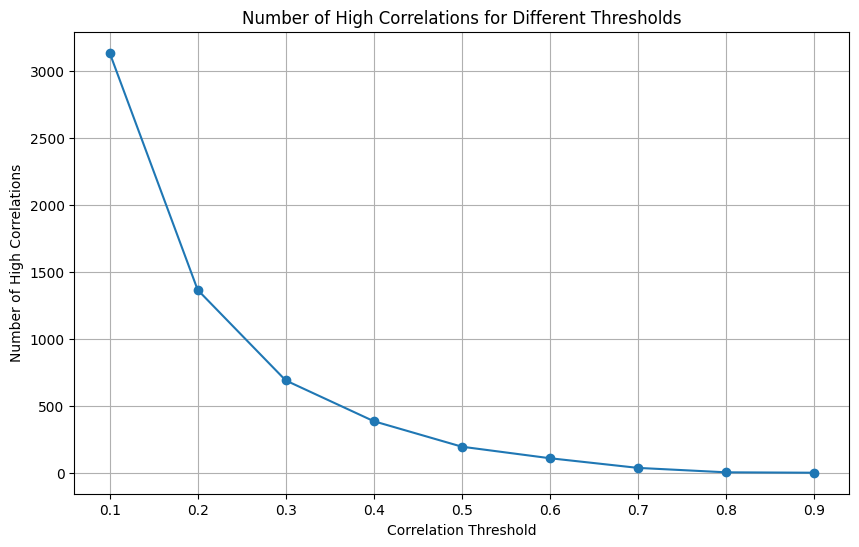

In [71]:
data.plot_high_corr()

In [72]:
print(f"At corr = .7: There are {len(data.find_high_corr(.7))} features")
print(f"At corr = .8: There are {len(data.find_high_corr(.8))} features")

At corr = .7: There are 37 features
At corr = .8: There are 4 features


In [73]:
removable_features = []

highCorr_features_map = data.find_high_corr(.8)

for _, highCorr_pairs in highCorr_features_map.items():
    for (feature1, feature2) in highCorr_pairs:
        insig_features = helper.hypothesis_test_features(data.train_df, feature1, feature2, alpha = .01)
        removable_features.extend(insig_features)

In [74]:
data.train_df.drop(removable_features, axis = consts.COL, inplace=True)

In [75]:
test_dfs = data.update_and_get_test_df(data_path=FILE_PATH, start_date=TEST_DATE)

Getting files from 2021-12-01 00:00:00 to 2021-12-01 00:00:00, inclusive.
Filtered File Dates: ['data.20211201_1200']



In [76]:
test_df = data.test_dfs[0]
test_df.shape

(3638, 251)

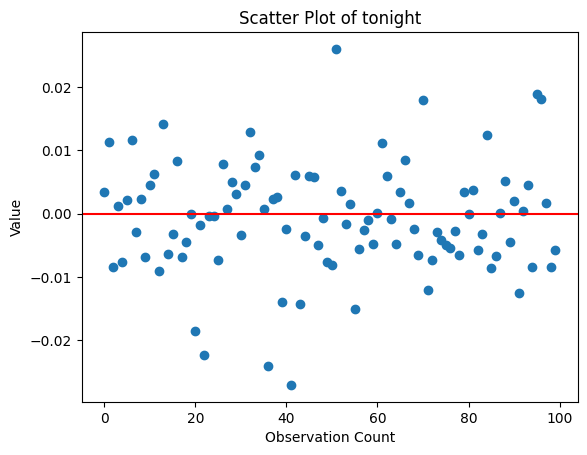

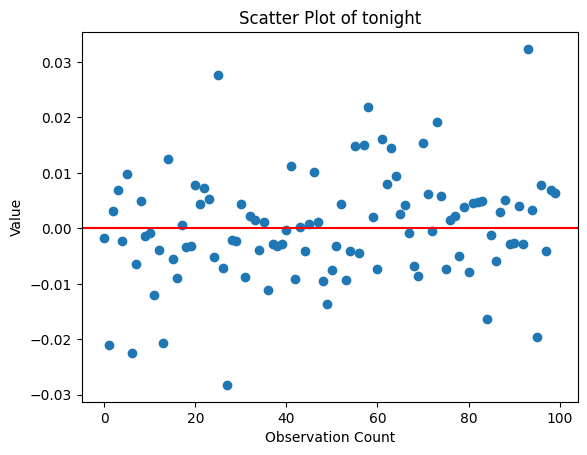

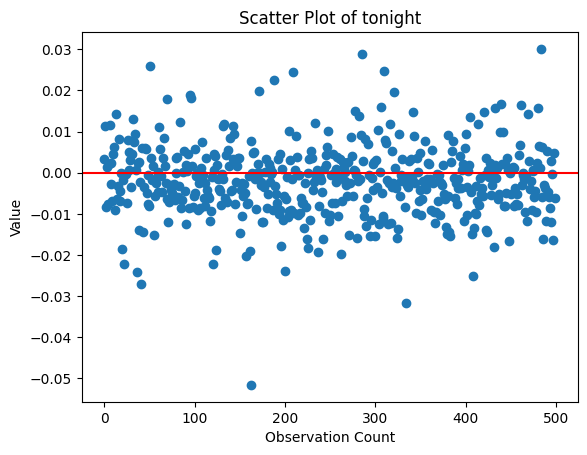

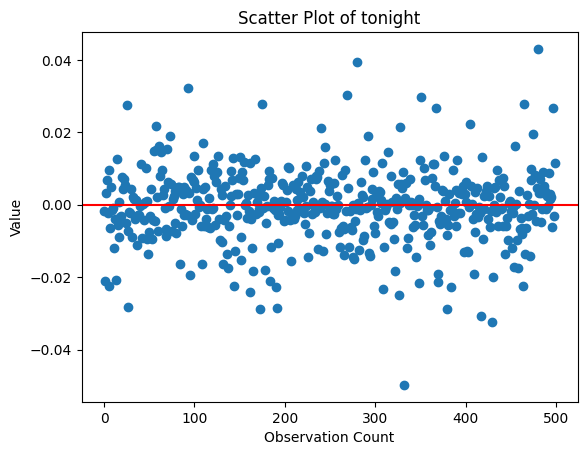

In [77]:
helper.scatter_lot(train_df, consts.RESPONSE_NAME, 100)
helper.scatter_lot(test_df, consts.RESPONSE_NAME, 100)
helper.scatter_lot(train_df, consts.RESPONSE_NAME, 500)
helper.scatter_lot(test_df, consts.RESPONSE_NAME, 500)

### Base Model

In [78]:
model1 = helper.Model('OLS')
model1.train(train_df)
model1.test(test_df)

You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 246
response_corr: 0.8597811400334376
mean_return: 0.009079263881253435
scale_factor: 0.9513413149927604


Getting files from 2021-10-31 00:00:00 to 2021-11-30 00:00:00, inclusive.
Filtered File Dates: ['data.20211101_1200', 'data.20211102_1200', 'data.20211103_1200', 'data.20211104_1200', 'data.20211105_1200', 'data.20211108_1200', 'data.20211109_1200', 'data.20211110_1200', 'data.20211111_1200', 'data.20211112_1200', 'data.20211115_1200', 'data.20211116_1200', 'data.20211117_1200', 'data.20211118_1200', 'data.20211119_1200', 'data.20211122_1200', 'data.20211123_1200', 'data.20211124_1200', 'data.20211126_1200', 'data.20211129_1200', 'data.20211130_1200']

Getting files from 2021-12-01 00:00:00 to 2021-12-16 00:00:00, inclusive.
Filtered File Dates: ['data.20211201_1200', 'data.20211202_1200', 'data.20211203_1200', 'data.20211206_1200', 'data.20211207_1200', 'data.20211208_1200', 'data.20211209_1200', 'data.20211210_1200', 'data.20211213_1200', 'data.20211214_1200', 'data.20211215_1200', 'data.20211216_1200']



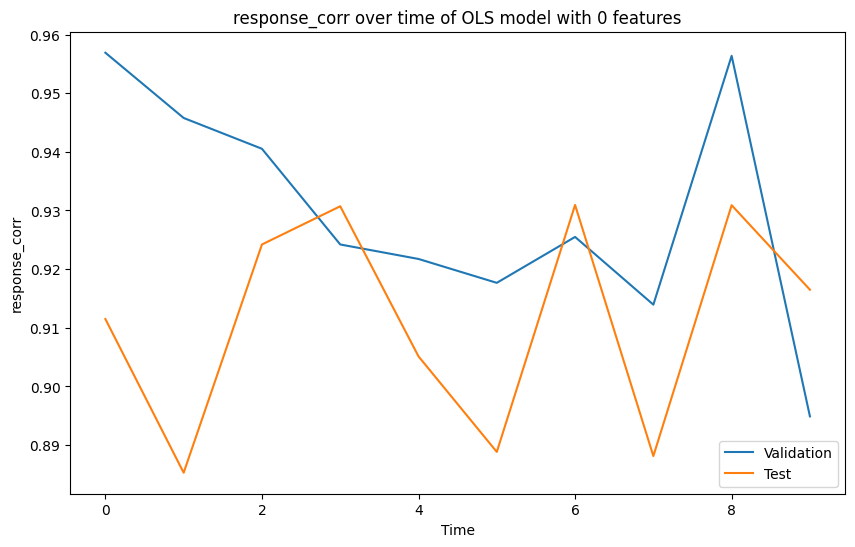

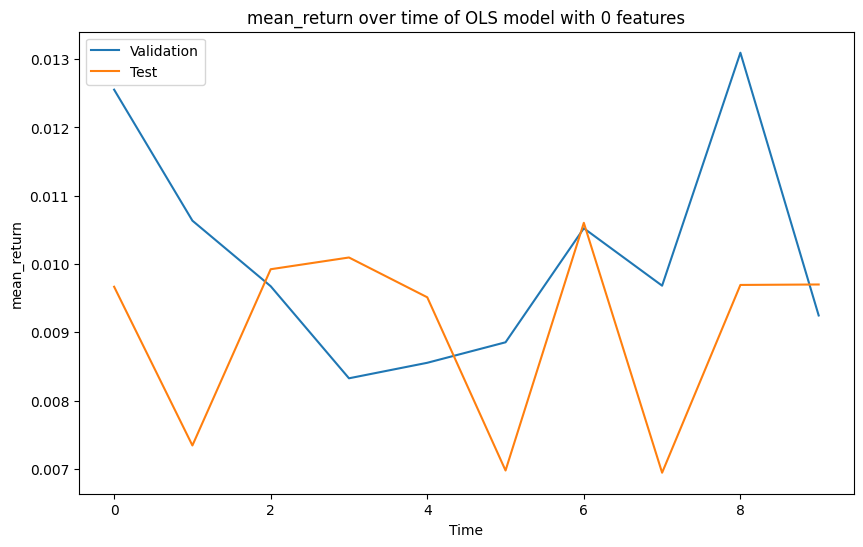

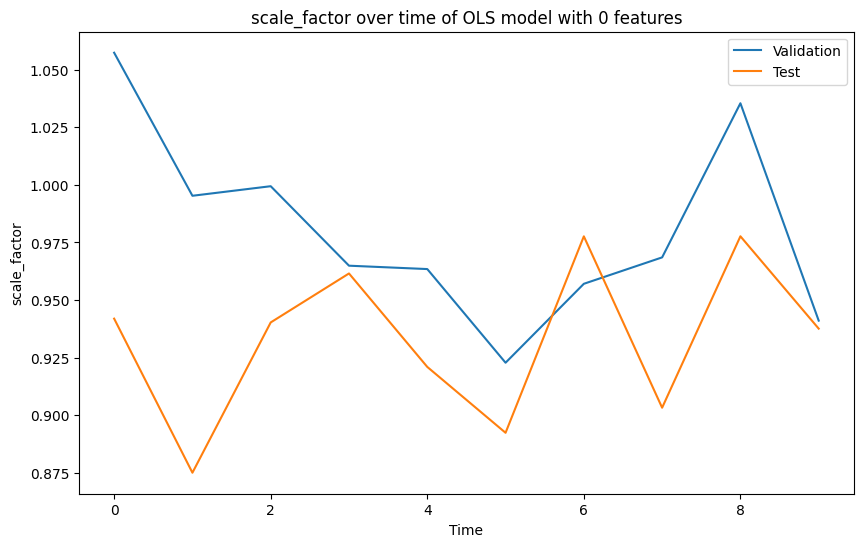

In [79]:
helper.validation_plot(data, model1, 10, "20211201", train_data_count=30, data_path=FILE_PATH, forward_dayCount = 15)

In [80]:
stepwise_features = helper.stepwise_selection(X = train_df.drop(consts.RESPONSE_NAME, inplace=False, axis = consts.COL), y = train_df[consts.RESPONSE_NAME])

Add dn1                            with p-value 0.0
Add tmwam                          with p-value 0.0
Add today                          with p-value 0.0
Add cftorrrelstd_open_0            with p-value 1.78953e-40
Add llirpnxm_toxhr_0               with p-value 8.10786e-27
Add totrisklog_open_0              with p-value 8.12846e-19
Add llirpnxm_lst15_0               with p-value 1.61661e-14
Add llirpnxm_dy_7to11              with p-value 1.84316e-13
Add dn4x1                          with p-value 5.43184e-14
Add llirpnxm_pm_1                  with p-value 8.35769e-11
Add llirpnxm_dy_4to6               with p-value 6.70651e-12
Add relvol_nt_17to21               with p-value 1.10513e-06
Add rrretstr_nt_0                  with p-value 3.28087e-07
Add tr_nt_1                        with p-value 8.39732e-07
Add relvol_lst15_0                 with p-value 2.76178e-06
Add rrirpnxm_lsthrx15_0            with p-value 2.95262e-05
Add relntrds70tr_am_1              with p-value 5.04143e-05
Add 

In [81]:
model2 = helper.Model('OLS')
model2.train(train_df, feature_col_names = stepwise_features)
model2.test(test_df)

You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 41
response_corr: 0.8654823201309918
mean_return: 0.009138500274876305
scale_factor: 0.9601329815962413


In [82]:
def LASSO_feature_selection(train_df, test_df, features = None):
    df = train_df.copy()
    temp_model = helper.Model('LASSO')
    
    if features == None: temp_model.train(df)
    else: temp_model.train(df, feature_col_names = features)
    temp_model.test(test_df)

    coefficients = temp_model.inner.coef_
    mask = np.not_equal(coefficients, 0)

    filtered_features = np.array(temp_model.feature_col_names)[mask]
    return filtered_features

In [83]:
lasso_features = LASSO_feature_selection(train_df, test_df)
lasso_stepwise_features = LASSO_feature_selection(train_df, test_df, features=stepwise_features)

You're using: LASSO.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False}


No. features being used: 246
response_corr: 0.871223098688735
mean_return: 0.009271060472787246
scale_factor: 0.9939670293770013
You're using: LASSO.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'alphas': None, 'copy_X': True, 'cv': None, 'eps': 0.001, 'fit_intercept': True, 'max_iter': 1000, 'n_alphas': 100, 'n_jobs': None, 'positive': False, 'precompute': 'auto', 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': False}
No. features being used: 41
response_corr: 0.8758903093962374
mean_return: 0.009297354040681693
scale_factor: 1.0066714872111058


In [84]:
model4 = helper.Model('OLS')
model4.train(train_df, feature_col_names = lasso_features)
model4.test(test_df)

You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 169
response_corr: 0.8689005175509565
mean_return: 0.009226229246838922
scale_factor: 0.9453374683197653


In [85]:
model5 = helper.Model('OLS')
model5.train(train_df, feature_col_names = stepwise_features)
model5.test(test_df)

You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 41
response_corr: 0.8654823201309918
mean_return: 0.009138500274876305
scale_factor: 0.9601329815962413


In [86]:
model6 = helper.Model('OLS')
model6.train(train_df, feature_col_names = lasso_stepwise_features)
model6.test(test_df)

You're using: OLS.
Remember: Model Class works with 1 training data and N testing data.
Your model's DEFAULT init hyperparams are: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
No. features being used: 32
response_corr: 0.8734567992649318
mean_return: 0.009306934029686641
scale_factor: 0.9563789784579884


Getting files from 2021-10-31 00:00:00 to 2021-11-30 00:00:00, inclusive.
Filtered File Dates: ['data.20211101_1200', 'data.20211102_1200', 'data.20211103_1200', 'data.20211104_1200', 'data.20211105_1200', 'data.20211108_1200', 'data.20211109_1200', 'data.20211110_1200', 'data.20211111_1200', 'data.20211112_1200', 'data.20211115_1200', 'data.20211116_1200', 'data.20211117_1200', 'data.20211118_1200', 'data.20211119_1200', 'data.20211122_1200', 'data.20211123_1200', 'data.20211124_1200', 'data.20211126_1200', 'data.20211129_1200', 'data.20211130_1200']

Getting files from 2021-12-01 00:00:00 to 2021-12-16 00:00:00, inclusive.
Filtered File Dates: ['data.20211201_1200', 'data.20211202_1200', 'data.20211203_1200', 'data.20211206_1200', 'data.20211207_1200', 'data.20211208_1200', 'data.20211209_1200', 'data.20211210_1200', 'data.20211213_1200', 'data.20211214_1200', 'data.20211215_1200', 'data.20211216_1200']



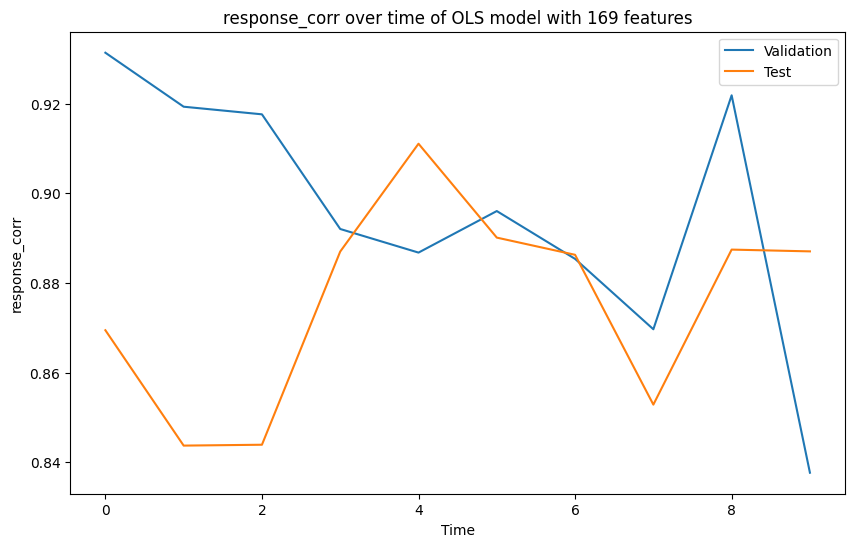

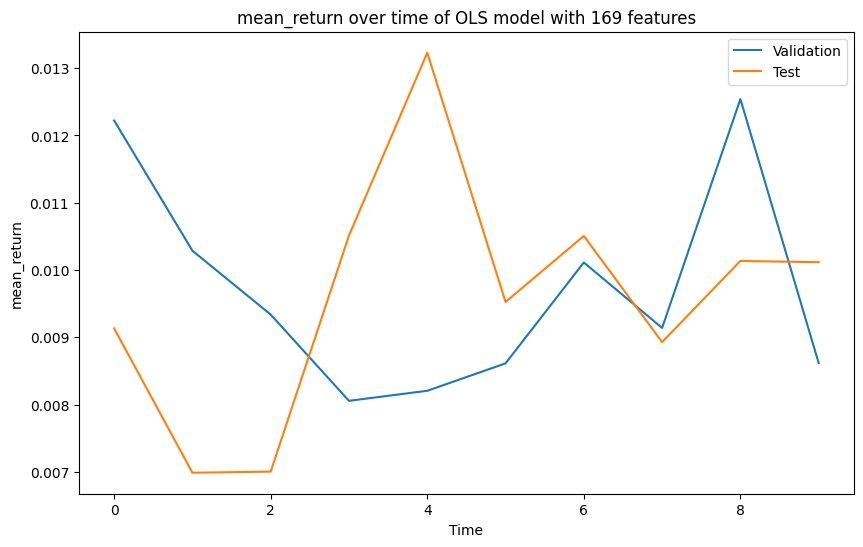

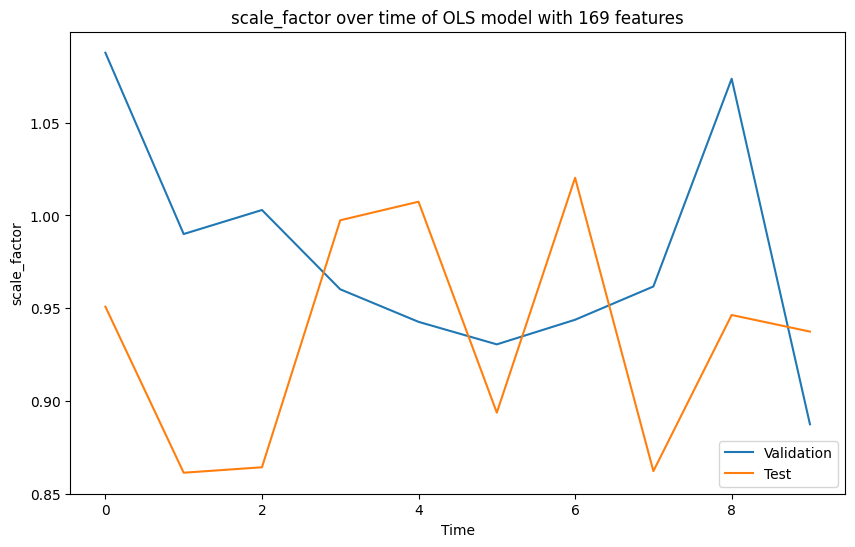

In [88]:
helper.validation_plot(data, model4, 10, "20211201", 
                       train_data_count=30, data_path=FILE_PATH,
                       forward_dayCount = 15, features = lasso_features)

Getting files from 2021-10-31 00:00:00 to 2021-11-30 00:00:00, inclusive.
Filtered File Dates: ['data.20211101_1200', 'data.20211102_1200', 'data.20211103_1200', 'data.20211104_1200', 'data.20211105_1200', 'data.20211108_1200', 'data.20211109_1200', 'data.20211110_1200', 'data.20211111_1200', 'data.20211112_1200', 'data.20211115_1200', 'data.20211116_1200', 'data.20211117_1200', 'data.20211118_1200', 'data.20211119_1200', 'data.20211122_1200', 'data.20211123_1200', 'data.20211124_1200', 'data.20211126_1200', 'data.20211129_1200', 'data.20211130_1200']

Getting files from 2021-12-01 00:00:00 to 2021-12-16 00:00:00, inclusive.
Filtered File Dates: ['data.20211201_1200', 'data.20211202_1200', 'data.20211203_1200', 'data.20211206_1200', 'data.20211207_1200', 'data.20211208_1200', 'data.20211209_1200', 'data.20211210_1200', 'data.20211213_1200', 'data.20211214_1200', 'data.20211215_1200', 'data.20211216_1200']



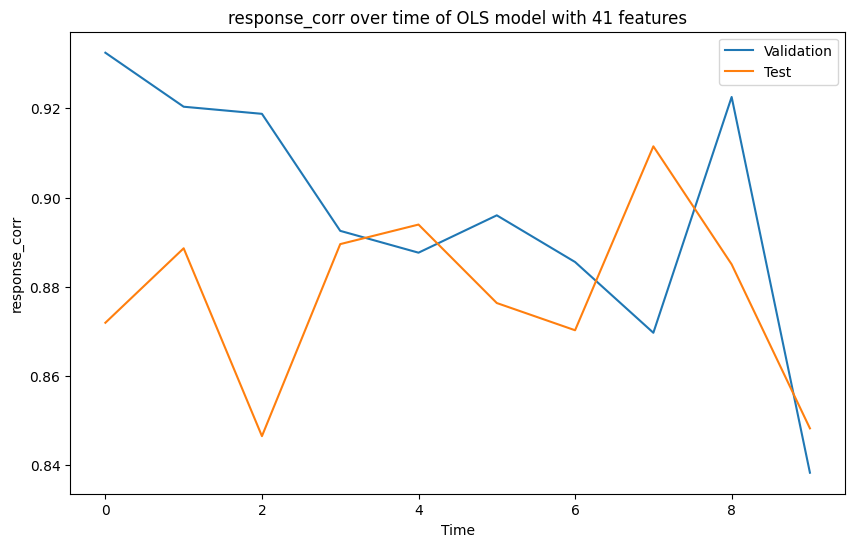

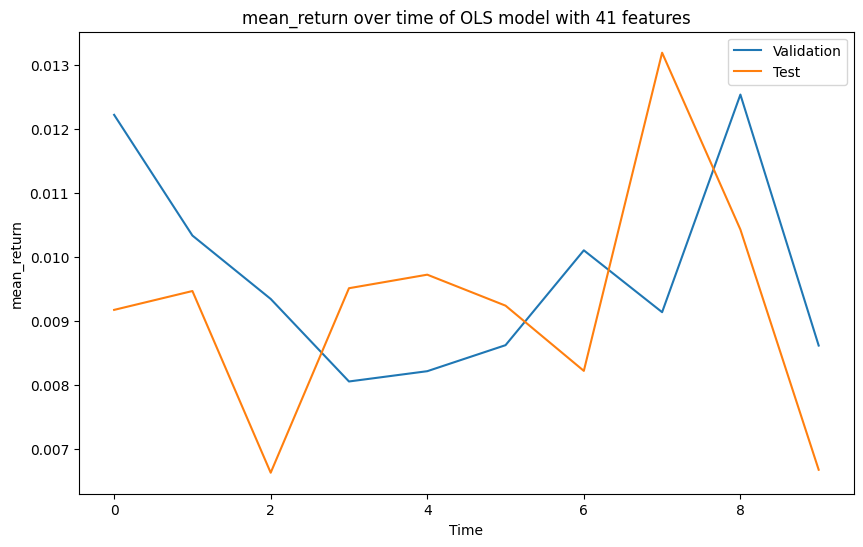

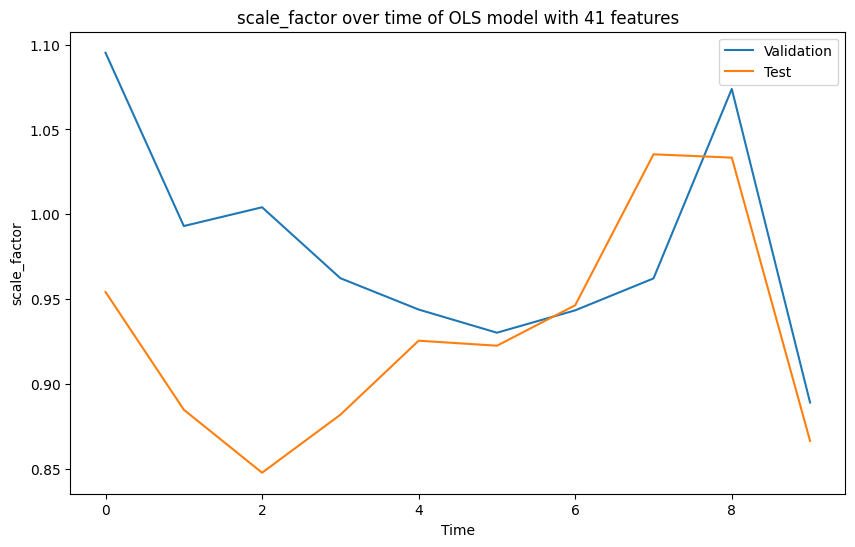

In [89]:
helper.validation_plot(data, model5, 10, "20211201", train_data_count=30, 
                       data_path=FILE_PATH, forward_dayCount = 15, features = stepwise_features)

Getting files from 2021-10-31 00:00:00 to 2021-11-30 00:00:00, inclusive.
Filtered File Dates: ['data.20211101_1200', 'data.20211102_1200', 'data.20211103_1200', 'data.20211104_1200', 'data.20211105_1200', 'data.20211108_1200', 'data.20211109_1200', 'data.20211110_1200', 'data.20211111_1200', 'data.20211112_1200', 'data.20211115_1200', 'data.20211116_1200', 'data.20211117_1200', 'data.20211118_1200', 'data.20211119_1200', 'data.20211122_1200', 'data.20211123_1200', 'data.20211124_1200', 'data.20211126_1200', 'data.20211129_1200', 'data.20211130_1200']

Getting files from 2021-12-01 00:00:00 to 2021-12-16 00:00:00, inclusive.
Filtered File Dates: ['data.20211201_1200', 'data.20211202_1200', 'data.20211203_1200', 'data.20211206_1200', 'data.20211207_1200', 'data.20211208_1200', 'data.20211209_1200', 'data.20211210_1200', 'data.20211213_1200', 'data.20211214_1200', 'data.20211215_1200', 'data.20211216_1200']



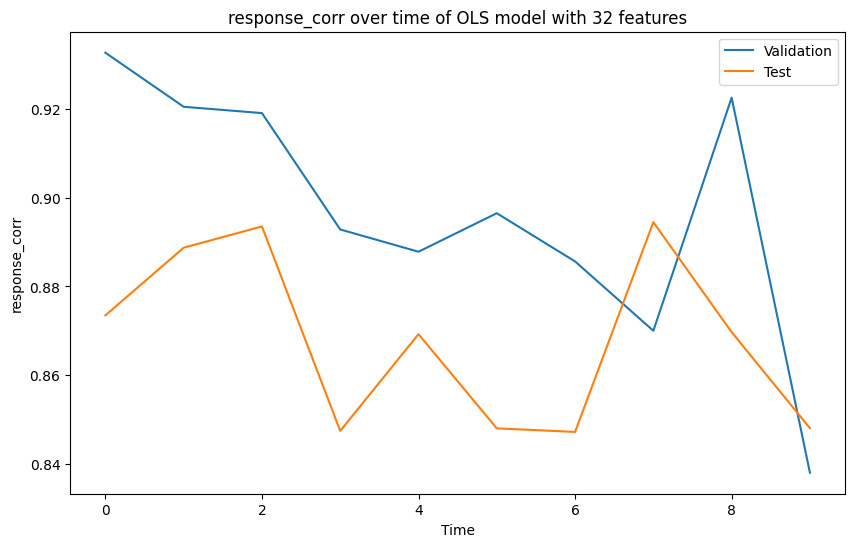

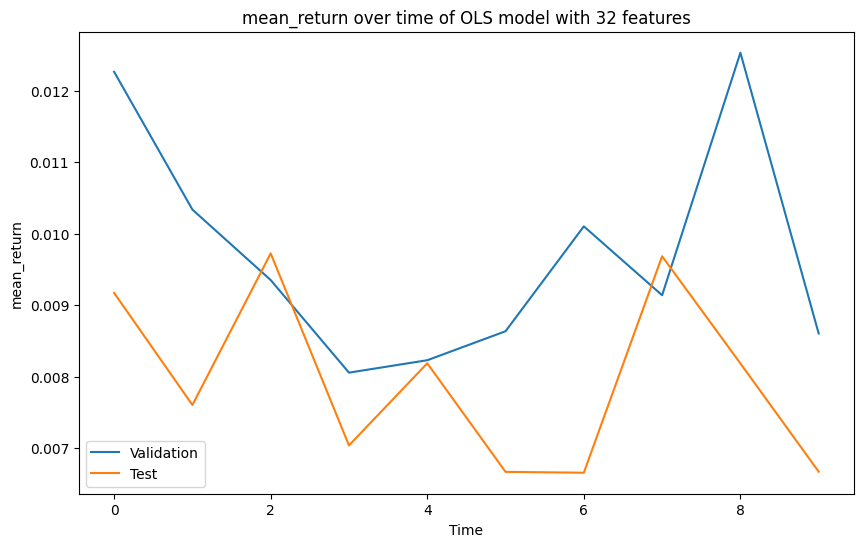

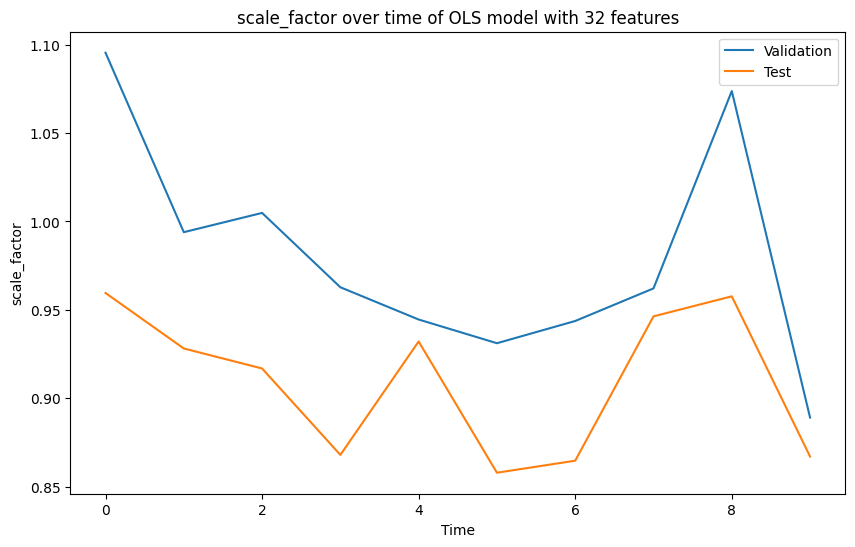

In [90]:
helper.validation_plot(data, model6, 10, "20211201", train_data_count=30, 
                       data_path=FILE_PATH, forward_dayCount = 15, features = lasso_stepwise_features)

In [91]:
export_path = "Hoang_features.txt"
helper.extract_features_to_file(lasso_stepwise_features, export_path)

In [92]:
export_path = "Hoang_LASSO_features.txt"
helper.extract_features_to_file(lasso_features, export_path)

In [93]:
export_path = "Hoang_stepwise_features.txt"
helper.extract_features_to_file(stepwise_features, export_path)